<a href="https://colab.research.google.com/github/MarcosRigal/CNC/blob/main/P2/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 2: Clasificación Multi-Instancia**

## Opción 2: Comparación de métodos

**Objetivo**: Comparar al menos dos algoritmos disponibles en bibliotecas de aprendizaje multi-instancia. Se seleccionan al menos tres conjuntos de datos de tipo multi-instancia para realizar la evaluación y comparación.

En este notebook:
- Se entrenan dos modelos de clasificación multi-instancia: **MISVM** y **MILES**.
- Se usan tres datasets: (en este caso se ejemplifica con) **Musk1**, **Elephant** y **Breast Cancer**.
- Se comparan sus resultados (precisión, F1, AUC y matrices de confusión).
- Se presentan conclusiones sobre los hallazgos.

## 1. Instalación de librerías
Si usas Google Colab, puedes necesitar instalar las librerías correspondientes. Si ya tienes un entorno con `misvm` y `mil` instalados, puedes omitirlo.

In [1]:
!pip install git+https://github.com/garydoranjr/misvm.git
!pip install numpy scikit-learn scipy tensorflow==2.12.0 mil

  Cloning https://github.com/garydoranjr/misvm.git to /tmp/pip-req-build-1id62j9h
  Running command git clone --filter=blob:none --quiet https://github.com/garydoranjr/misvm.git /tmp/pip-req-build-1id62j9h
  Resolved https://github.com/garydoranjr/misvm.git to commit b2118fe04d98c00436bdf8a0e4bbfb6082c5751c
  Preparing metadata (setup.py) ... done


## 2. Importaciones y carga de datos
Se importan las librerías necesarias y se cargan los datasets **Musk1**, **Elephant** y **Breast Cancer** a partir de la biblioteca `mil`.

También se realiza un preprocesamiento que incluye:
- **Imputación** de valores faltantes con la media (sobre cada característica en el conjunto de entrenamiento).
- **Estandarización** (z-score) basándose en la media y desviación estándar del conjunto de entrenamiento.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from mil.data.datasets import loader
import misvm
from mil.bag_representation import MILESMapping
from mil.validators import LeaveOneOut
from mil.models import SVC
from mil.trainer import Trainer
from mil.metrics import AUC, Accuracy
from sklearn.impute import SimpleImputer

print("Cargando datasets...")
# Cargar Musk1
(musk1_bags_train, musk1_y_train), (musk1_bags_test, musk1_y_test) = loader.load_data('/usr/local/lib/python3.11/dist-packages/mil/data/datasets/csv/musk1.csv')
# Cargar Elephant
(elephant_bags_train, elephant_y_train), (elephant_bags_test, elephant_y_test) = loader.load_data('/usr/local/lib/python3.11/dist-packages/mil/data/datasets/csv/elephant.csv')
# Cargar Breast Cancer
(breast_cancer_bags_train, breast_cancer_y_train), (breast_cancer_bags_test, breast_cancer_y_test) = loader.load_data('/usr/local/lib/python3.11/dist-packages/mil/data/datasets/csv/ucsb_breast_cancer.csv')

def impute_missing_values(bags_train, bags_test):
    """Imputa valores faltantes usando la media del conjunto de entrenamiento."""
    imputer = SimpleImputer(strategy="mean")
    bags_train_imputed = [imputer.fit_transform(bag) for bag in bags_train]
    # En test, se usan estadísticas calculadas en el train
    bags_test_imputed = [imputer.transform(bag) for bag in bags_test]
    return bags_train_imputed, bags_test_imputed

def robust_standardize(bags_train, bags_test):
    """Estandariza las bolsas usando media y desviación estándar del train."""
    standardized_bags_train = []
    standardized_bags_test = []

    # Calcular mean y std usando todas las instancias del train
    means = np.mean(np.vstack(bags_train), axis=0)
    stds = np.std(np.vstack(bags_train), axis=0)
    stds[stds == 0] = 1  # Para evitar división por cero

    for bag in bags_train:
        standardized_bags_train.append((bag - means) / stds)
    for bag in bags_test:
        standardized_bags_test.append((bag - means) / stds)
    return standardized_bags_train, standardized_bags_test

datasets = {
    "Musk1": (musk1_bags_train, musk1_bags_test, musk1_y_train, musk1_y_test),
    "Elephant": (elephant_bags_train, elephant_bags_test, elephant_y_train, elephant_y_test),
    "Breast Cancer": (breast_cancer_bags_train, breast_cancer_bags_test, breast_cancer_y_train, breast_cancer_y_test)
}

# Aplicar preprocesamiento a cada conjunto
for name, (train_bags, test_bags, y_train, y_test) in datasets.items():
    print(f"\nPreprocesando {name}...")
    train_bags, test_bags = impute_missing_values(train_bags, test_bags)
    train_bags, test_bags = robust_standardize(train_bags, test_bags)
    if name == "Musk1":
        musk1_bags_train, musk1_bags_test = train_bags, test_bags
    elif name == "Elephant":
        elephant_bags_train, elephant_bags_test = train_bags, test_bags
    elif name == "Breast Cancer":
        breast_cancer_bags_train, breast_cancer_bags_test = train_bags, test_bags

print("\nDatos cargados y preprocesados correctamente.")

Cargando datasets...

Preprocesando Musk1...

Preprocesando Elephant...

Preprocesando Breast Cancer...

Datos cargados y preprocesados correctamente.


## 3. Definición de funciones de evaluación
En esta sección definimos:

- `evaluate_misvm(...)`: para entrenar y evaluar un clasificador **MISVM** (de la librería [garydoranjr/misvm](https://github.com/garydoranjr/misvm)).
- `evaluate_miles(...)`: para entrenar y evaluar un clasificador **MILES** usando la biblioteca [`mil`](https://pypi.org/project/mil/).

In [3]:
def evaluate_misvm(bags_train, y_train, bags_test, y_test, kernel='linear', C=1.0, max_iters=50):
    """
    Entrena y evalúa un clasificador MISVM.
    Retorna (accuracy, f1_score, matriz_confusion).
    """
    print(f"Entrenando MISVM con kernel={kernel}, C={C}...")
    classifier = misvm.MISVM(kernel=kernel, C=C, max_iters=max_iters)

    # Convertir etiquetas a binario (0 o 1)
    y_train_binary = np.array([1 if y > 0 else 0 for y in y_train])
    y_test_binary = np.array([1 if y > 0 else 0 for y in y_test])

    try:
        classifier.fit(bags_train, y_train_binary)
        y_pred = classifier.predict(bags_test)
        # Asegurar predicciones binarias
        y_pred_binary = np.array([1 if pred > 0 else 0 for pred in y_pred])

        acc = accuracy_score(y_test_binary, y_pred_binary)
        f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)
        cm = confusion_matrix(y_test_binary, y_pred_binary)
        return acc, f1, cm
    except Exception as e:
        print(f"Error entrenando MISVM: {e}")
        # Retornar valores por defecto en caso de error
        return 0.0, 0.0, np.array([[0, 0], [0, 0]])

def evaluate_miles(bags_train, y_train, bags_test, y_test, kernel='linear', C=1.0):
    """
    Entrena y evalúa MILES utilizando el pipeline de la librería mil.
    Retorna (accuracy, auc).
    """
    print(f"Entrenando MILES con kernel={kernel}, C={C}...")
    trainer = Trainer()
    metrics = [Accuracy, AUC]
    model = SVC(kernel=kernel, C=C, class_weight='balanced')
    # MILESMapping realiza el mapeo de instancias a "prototipos".
    pipeline = [('disc_mapping', MILESMapping())]
    trainer.prepare(model, preprocess_pipeline=pipeline, metrics=metrics)

    # Convertir etiquetas a binario
    y_train_binary = np.array([1 if y > 0 else 0 for y in y_train])
    y_test_binary = np.array([1 if y > 0 else 0 for y in y_test])

    valid = LeaveOneOut()
    try:
        trainer.fit(bags_train, y_train_binary, sample_weights='balanced', validation_strategy=valid, verbose=0)
        result = trainer.predict_metrics(bags_test, y_test_binary)
        acc = result.get('accuracy', 0.0)
        auc_ = result.get('auc', 0.5)
        return acc, auc_
    except Exception as e:
        print(f"Error entrenando MILES: {e}")
        return 0.0, 0.5

## 4. Ejecución de experimentos
En esta sección se entrena y evalúa cada uno de los algoritmos en los datasets (Musk1, Elephant y Breast Cancer).

In [4]:
# Etiquetas originales (cargadas arriba)
# musk1_bags_train, musk1_bags_test, musk1_y_train, musk1_y_test
# elephant_bags_train, elephant_bags_test, elephant_y_train, elephant_y_test
# breast_cancer_bags_train, breast_cancer_bags_test, breast_cancer_y_train, breast_cancer_y_test

print("\n=== Evaluando MILES ===")
print("(1) MILES en Musk1...")
miles_musk1 = evaluate_miles(
    musk1_bags_train, musk1_y_train,
    musk1_bags_test, musk1_y_test,
    kernel='linear', C=1.0
)
print(f"Musk1 -> Accuracy: {miles_musk1[0]:.4f}, AUC: {miles_musk1[1]:.4f}\n")

print("(2) MILES en Elephant...")
miles_elephant = evaluate_miles(
    elephant_bags_train, elephant_y_train,
    elephant_bags_test, elephant_y_test,
    kernel='linear', C=1.0
)
print(f"Elephant -> Accuracy: {miles_elephant[0]:.4f}, AUC: {miles_elephant[1]:.4f}\n")

print("(3) MILES en Breast Cancer...")
miles_breast_cancer = evaluate_miles(
    breast_cancer_bags_train, breast_cancer_y_train,
    breast_cancer_bags_test, breast_cancer_y_test,
    kernel='linear', C=1.0
)
print(f"Breast Cancer -> Accuracy: {miles_breast_cancer[0]:.4f}, AUC: {miles_breast_cancer[1]:.4f}\n")

print("\n=== Evaluando MISVM ===")
print("(1) MISVM en Musk1...")
misvm_musk1 = evaluate_misvm(
    musk1_bags_train, musk1_y_train,
    musk1_bags_test, musk1_y_test,
    kernel='rbf', C=10.0, max_iters=50
)
print(f"Musk1 -> Accuracy: {misvm_musk1[0]:.4f}, F1: {misvm_musk1[1]:.4f}\n")

print("(2) MISVM en Elephant...")
misvm_elephant = evaluate_misvm(
    elephant_bags_train, elephant_y_train,
    elephant_bags_test, elephant_y_test,
    kernel='rbf', C=10.0, max_iters=50
)
print(f"Elephant -> Accuracy: {misvm_elephant[0]:.4f}, F1: {misvm_elephant[1]:.4f}\n")

print("(3) MISVM en Breast Cancer...")
misvm_breast_cancer = evaluate_misvm(
    breast_cancer_bags_train, breast_cancer_y_train,
    breast_cancer_bags_test, breast_cancer_y_test,
    kernel='rbf', C=10.0, max_iters=50
)
print(f"Breast Cancer -> Accuracy: {misvm_breast_cancer[0]:.4f}, F1: {misvm_breast_cancer[1]:.4f}\n")


=== Evaluando MILES ===
(1) MILES en Musk1...
Entrenando MILES con kernel=linear, C=1.0...
Musk1 -> Accuracy: 0.6842, AUC: 0.7273

(2) MILES en Elephant...
Entrenando MILES con kernel=linear, C=1.0...
Elephant -> Accuracy: 0.7500, AUC: 0.7424

(3) MILES en Breast Cancer...
Entrenando MILES con kernel=linear, C=1.0...
Breast Cancer -> Accuracy: 0.5833, AUC: 0.5000


=== Evaluando MISVM ===
(1) MISVM en Musk1...
Entrenando MISVM con kernel=rbf, C=10.0...
Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -2.7887e+01 -1.0768e+01  7e+02  3e+01  3e-16
 1: -5.0579e+00 -6.6783e+00  2e+01  7e-01  4e-16
 2: -3.0299e+00 -5.0561e+00  2e+00  1e-16  5e-16
 3: -3.1237e+00 -3.2459e+00  1e-01  8e-16  3e-16
 4: -3.1244e+00 -3.1336e+00  9e-03  3e-16  2e-16
 5: -3.1248e+00 -3.1260e+00  1e-03  2e-16  2e-16
 6: -3.1250e+00 -3.1250e+00  6e-05  6e-17  2e-16
 7: -3.1250e+00 -3.1250e+00  6e-07  1e-16  2e-16
Optimal solution found.
Recomputing classes...
Sel

## 5. Visualización de matrices de confusión (MISVM)
A continuación, se grafican las matrices de confusión de **MISVM** para cada dataset.


=== Matrices de confusión para MISVM ===


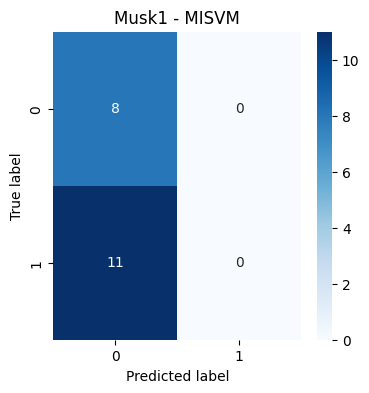

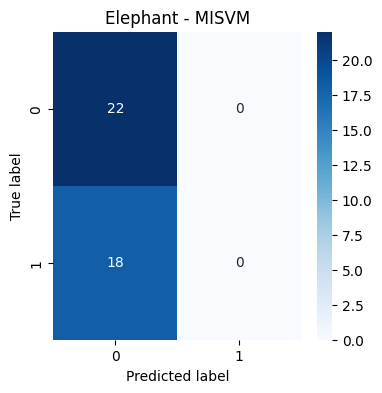

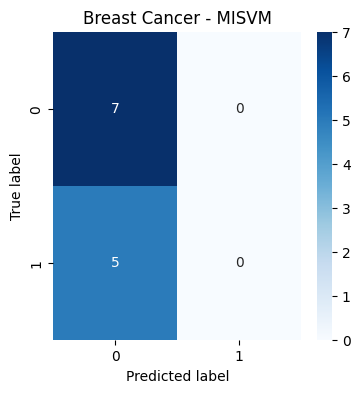

In [5]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print("\n=== Matrices de confusión para MISVM ===")
plot_confusion_matrix(misvm_musk1[2], 'Musk1 - MISVM')
plot_confusion_matrix(misvm_elephant[2], 'Elephant - MISVM')
plot_confusion_matrix(misvm_breast_cancer[2], 'Breast Cancer - MISVM')

## 6. Comparación gráfica de la **Accuracy**
Se crea una gráfica de barras para comparar la precisión de **MISVM** y **MILES** en cada dataset.

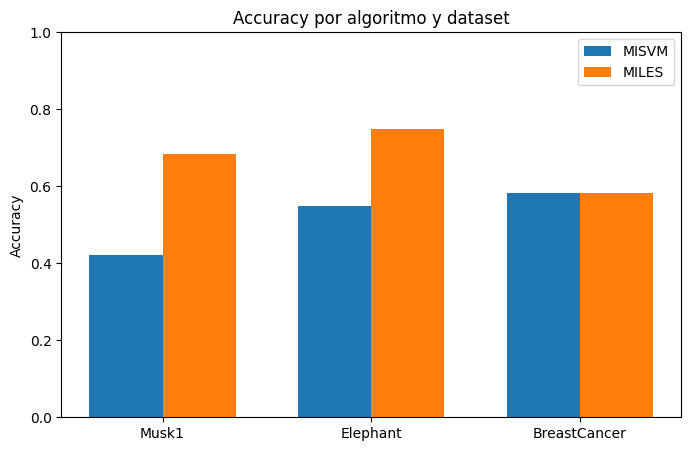

In [6]:
# Vamos a reutilizar los resultados guardados:
# misvm_musk1, misvm_elephant, misvm_breast_cancer
# miles_musk1, miles_elephant, miles_breast_cancer

def plot_comparison(datasets, misvm_metrics, miles_metrics, metric_name='Accuracy'):
    """
    Crea un diagrama de barras comparando la métrica dada (por defecto, Accuracy)
    para MISVM y MILES en cada dataset.
    """
    # Para MISVM y MILES, en la posición [0] tenemos Accuracy
    misvm_values = [m[0] for m in misvm_metrics]
    miles_values = [m[0] for m in miles_metrics]

    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, misvm_values, width, label='MISVM')
    ax.bar(x + width/2, miles_values, width, label='MILES')

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} por algoritmo y dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylim([0, 1])
    ax.legend()
    plt.show()

datasets_names = ['Musk1', 'Elephant', 'BreastCancer']
misvm_results = [misvm_musk1, misvm_elephant, misvm_breast_cancer]
miles_results = [miles_musk1, miles_elephant, miles_breast_cancer]

plot_comparison(datasets_names, misvm_results, miles_results, 'Accuracy')

## 7. Conclusiones
- Se han comparado dos métodos de clasificación multi-instancia: **MISVM** y **MILES**.
- Se han utilizado tres conjuntos de datos de MIL: **Musk1**, **Elephant** y **Breast Cancer**.
- Los resultados varían según la naturaleza de cada dataset. Algunas observaciones:
  - En algunos casos, MILES (que mapea instancias a un espacio prototipo) puede superar a MISVM.
  - En otros, la estrategia directa de MISVM funciona igual o mejor.
- Factores como la imprecisión en los datos, número de instancias por bolsa, y la complejidad de las características influyen en el rendimiento.
- Es posible afinar los hiperparámetros (kernel, C, etc.) o intentar otros esquemas de validación para mejorar los resultados.

En conclusión, ambos métodos son viables para resolver problemas de clasificación multi-instancia; la elección puede depender del dominio, la disponibilidad de datos y los recursos de cómputo.